In [1]:
%load_ext autoreload
%autoreload 3 --log
%autoreload?

Docstring:
::

  %autoreload [-p] [-l] [--hide-errors] [mode]

%autoreload => Reload modules automatically

%autoreload or %autoreload now
Reload all modules (except those excluded by %aimport) automatically
now.

%autoreload 0 or %autoreload off
Disable automatic reloading.

%autoreload 1 or %autoreload explicit
Reload only modules imported with %aimport every time before executing
the Python code typed.

%autoreload 2 or %autoreload all
Reload all modules (except those excluded by %aimport) every time
before executing the Python code typed.

%autoreload 3 or %autoreload complete
Same as 2/all, but also but also adds any new objects in the module. See
unit test at IPython/extensions/tests/test_autoreload.py::test_autoload_newly_added_objects

The optional arguments --print and --log control display of autoreload activity. The default
is to act silently; --print (or -p) will print out the names of modules that are being
reloaded, and --log (or -l) outputs them to the log at INFO level.

In [2]:
from stpy.kernels import KernelFunction
from stpy.borel_set import BorelSet,HierarchicalBorelSets
from stpy.point_processes.poisson_rate_estimator import PoissonRateEstimator
import torch 
import pandas as pd
import geopandas
import numpy as np 
import matplotlib.pyplot as plt
import contextily as ctx
from scipy.interpolate import griddata
from stpy.point_processes.poisson.poisson import PoissonPointProcess
from sensepy.capture_thompson import CaptureThompson
import time
from utils import *

2024-11-12 21:33:32.677129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731443612.692942   10538 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731443612.697902   10538 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 21:33:32.713334: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from stpy.embeddings.triangle_base import EfficientTriangleEmbedding
from stpy.embeddings.optimal_positive_basis import OptimalPositiveBasis
from stpy.point_processes.link_fun_rate_estimator import ExpGaussProcessRateEstimator
kernel = KernelFunction(kernel_name="squared_exponential", gamma=0.12, d=2)
m = 10
min_intensity = 0.0
max_intensity = 1.0
offset=0.1
jitter = 1e-7
estimator = ExpGaussProcessRateEstimator(
    HierarchicalBorelSets(
        d=2, interval=[(-1, 1), (-1, 1)], levels=5
    ),  # 4^(8-1) cells in the lowest level
    d=2,
    kernel=kernel,
    max_intensity=max_intensity,  # maximal value of the rate function
    min_intensity=min_intensity,  # minimal value of the rate function
    basis_size_per_dim=m,  # number of basis functions along each axis
    langevine_sampling_steps=200,  # langevin steps for sampling
    optimization_library="cvxpy",
    use_anchors=False,
    basis="optimal-positive",
    offset=offset,
    # embedding=OptimalPositiveBasis(
    #     2,
    #     m,
    #     kernel_object=KernelFunction(
    #         kernel_name="squared_exponential", gamma=0.12, d=2
    #     ),
    #     b=min_intensity,
    #     B=max_intensity,
    #     offset=offset,
    #     s=np.sqrt(jitter),
    #     samples=100,
    # ),
)

Optimal basis with arbitrary dimension, namely d = 2
Starting optimal basis construction, with m = 10
Optimal basis constructed.
Precomputation finished.


In [4]:
name = "sensepy/sensepy/benchmarks/data/taxi_data.csv"
Num_data_points = 200
# borel set a square with boundaries [-1,1]^2
D = BorelSet(2, bounds=torch.Tensor([[-1.0, 1.0], [-1, 1]]).double())
obs, dt, gdf = get_taxi_data(Num_data_points)
data = [(D, obs, dt)]

In [5]:
# load data in the above format
st = time.process_time()
estimator.load_data(data)
et = time.process_time()
print("Time to load data: ", et-st)

nodes of functions torch.Size([10, 2])
Time to load data:  45.87276320000001


In [6]:
# fit the Cox process by calculating MAP. Method is defined by estimator.estimator
# it is set to penalized_likelihood, so we do the posterior GP approximation by
# the sensing paper. Also estimator.feedback is set to count-record so no histogram
# By default dual = True which means that data is split into buckets that
# are given by the quadtree
estimator.dual = False
st = time.process_time()
estimator.fit_gp()
et = time.process_time()
print("Time to fit GP: ", et-st)

Time to fit GP:  0.06884839999997894


In [7]:
left, down, right, up = gdf.total_bounds

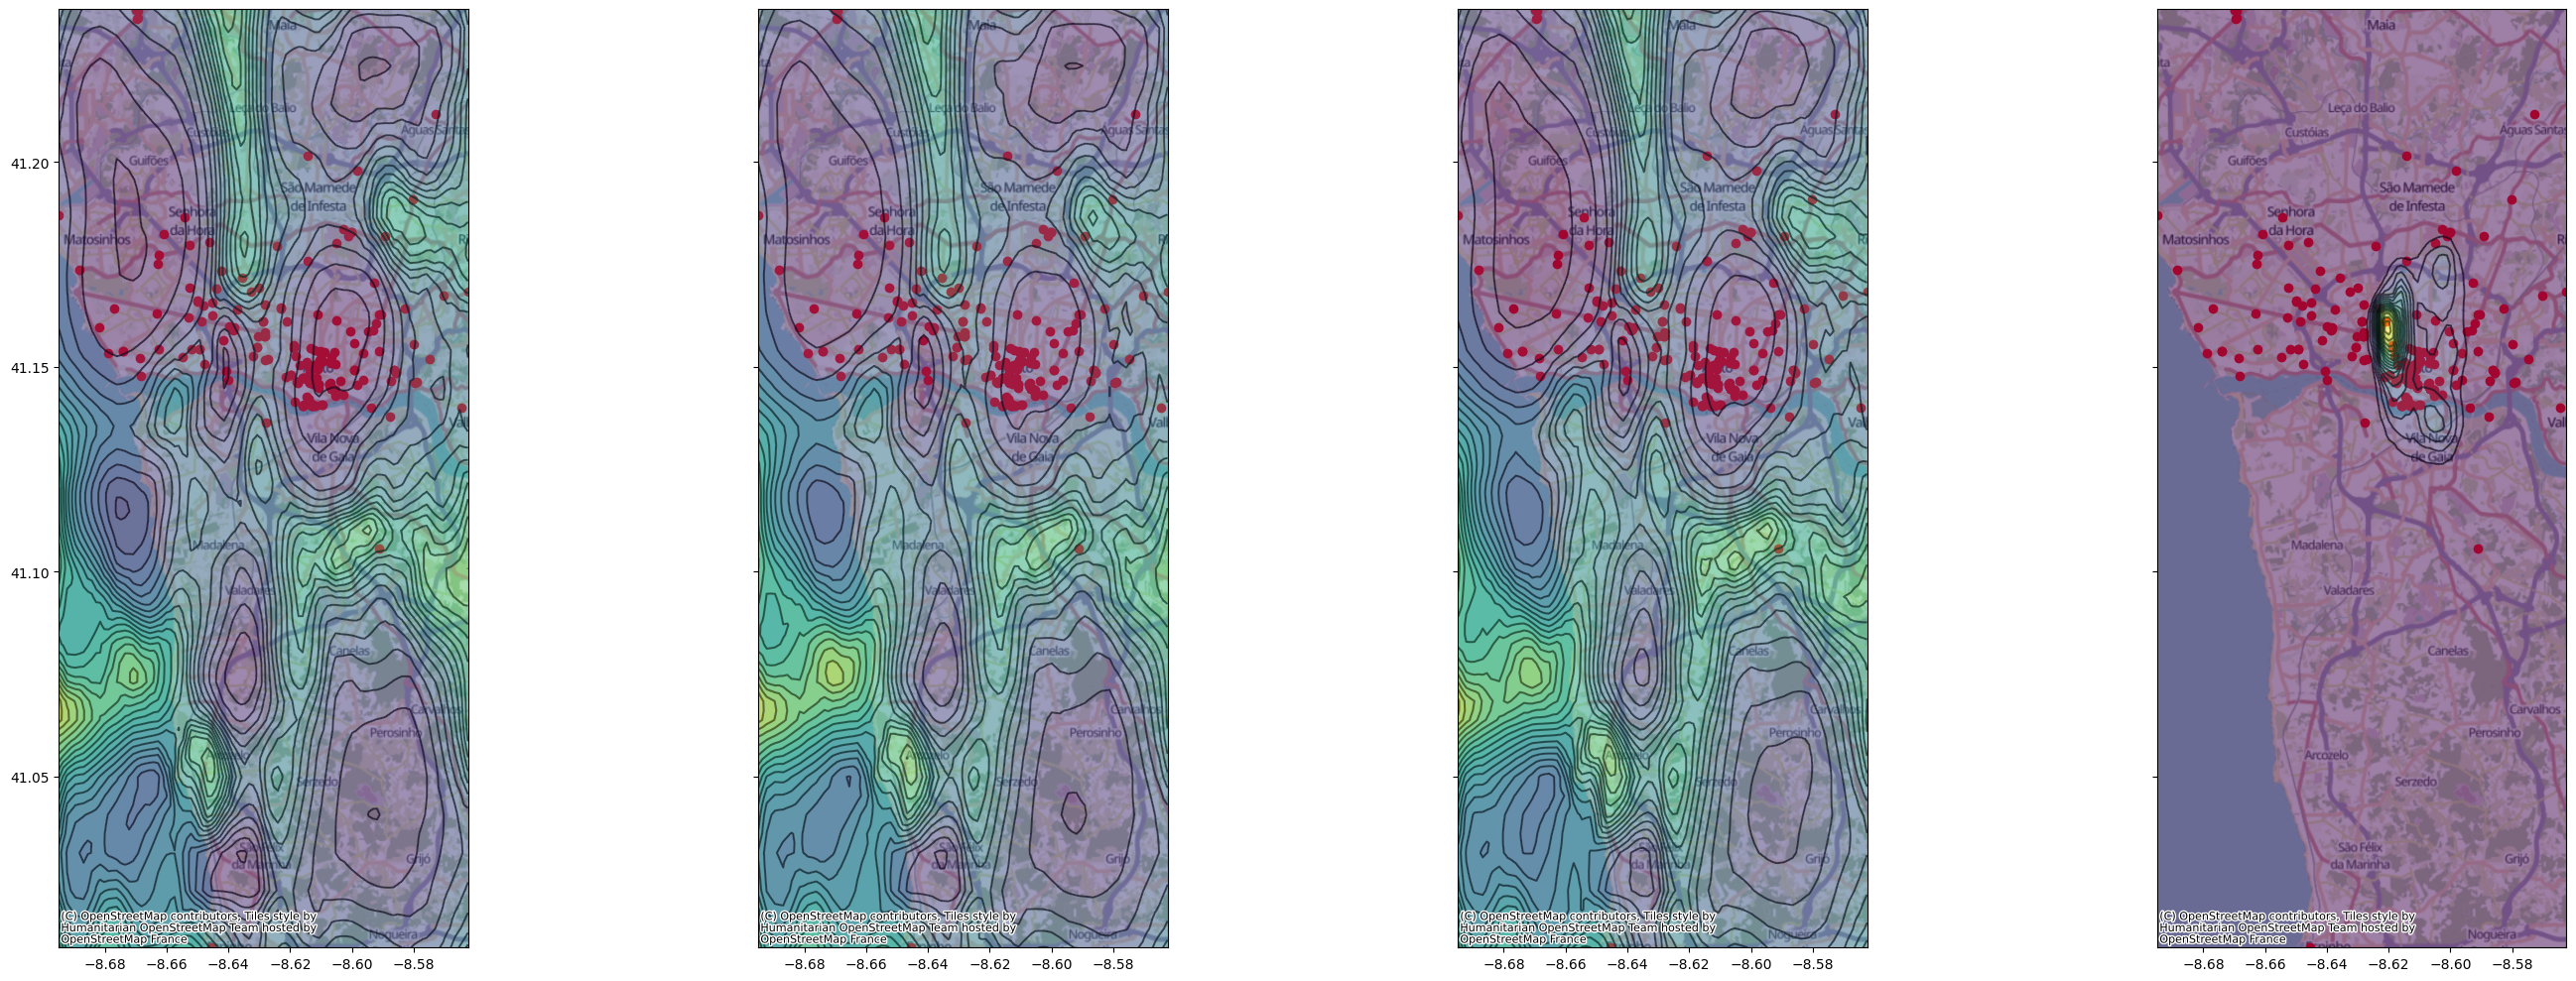

In [ ]:
# Sampling not implemented!

n = 50  # discretization
k = 3  # number of samples to draw and plot

xtest = D.return_discretization(n)
Map = BorelSet(d=2, bounds=torch.Tensor([[left, right], [down, up]]).double())
xtest_orig = Map.return_discretization(n).numpy()

xx = xtest_orig[:, 0]
yy = xtest_orig[:, 1]
grid_x, grid_y = np.mgrid[min(xx) : max(xx) : 100j, min(yy) : max(yy) : 100j]

# Set up the plot
fig, axs = plt.subplots(1, k + 1, figsize=(10 * k, 10), sharey=True)

# Sample and plot for each subplot
for i in range(k + 1):
    # Generate a sample path
    if i < k:
        estimator.sample(steps=200, verbose=False)
        f = estimator.sample_path(D, n)
    else:
        f = estimator.mean_rate(D, n).unsqueeze(-1)

    # Interpolate function values for contour plot
    grid_z_f = griddata(
        (xx, yy), f[:, 0].detach().numpy(), (grid_x, grid_y), method="linear"
    )

    # Plot on subplot
    ax = axs[i]
    gdf.plot(ax=ax, color="red", figsize=(10, 10))
    cs = ax.contourf(grid_x, grid_y, grid_z_f, levels=20, alpha=0.5)
    ax.contour(cs, colors="k", alpha=0.5)
    # fig.colorbar(cs, ax=ax)
    ctx.add_basemap(ax, crs=gdf.crs.to_string())

plt.tight_layout()
plt.show()

In [ ]:
# Parameters
n = 50  # Discretization
xtest = D.return_discretization(n)
Map = BorelSet(d=2, bounds=torch.Tensor([[left, right], [down, up]]).double())
xtest_orig = Map.return_discretization(n).numpy()

# Prepare coordinates for plotting
xx = xtest_orig[:, 0]
yy = xtest_orig[:, 1]

# Calculate mean and standard deviation across samples at each point
mean_values = estimator.mean_rate(D, n)
std_values = torch.zeros_like(mean_values)

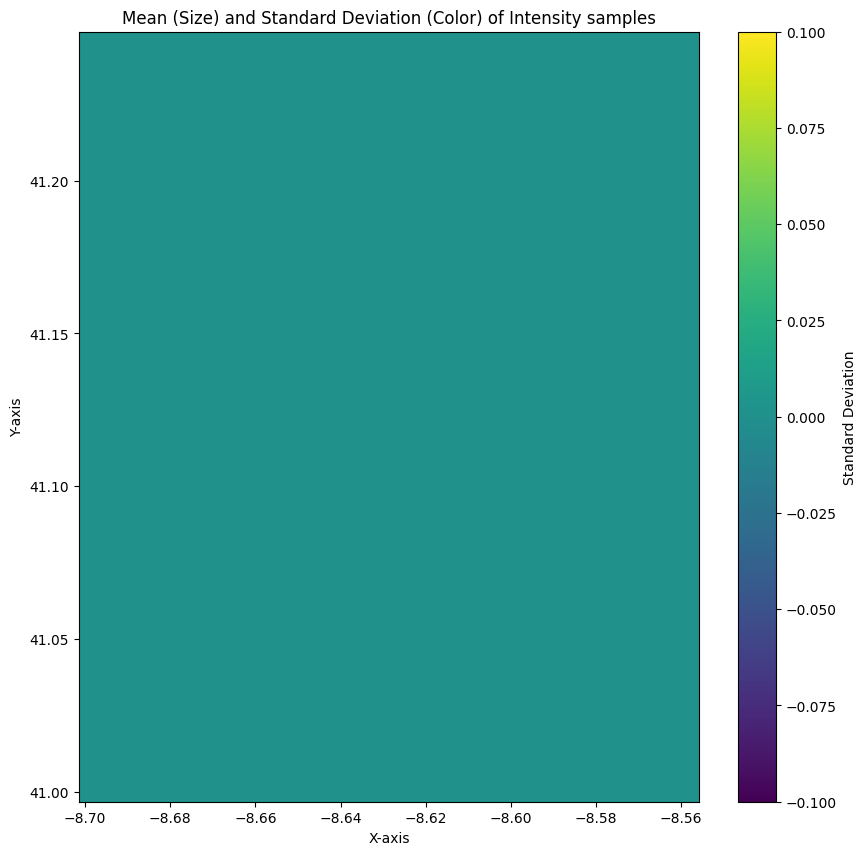

In [11]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Define a scaling factor for the sizes based on mean values
scale_factor = 100  # Adjust this factor as needed for visual clarity

# Scatter plot with mean values as size and std as color using viridis colormap
scatter = ax.scatter(
    xx,
    yy,
    c=std_values,
    cmap="viridis",
    s=mean_values,  # Scale point size by mean values
    alpha=1.0,
    edgecolor="face",
    linewidth=0.0,
    marker="o",
)

# ctx.add_basemap(ax, crs=gdf.crs.to_string())

# Color bar for the standard deviation (variance)
cbar = fig.colorbar(scatter, ax=ax, label="Standard Deviation")

# Labeling
ax.set_title("Mean (Size) and Standard Deviation (Color) of Intensity samples")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")

plt.show()

In [ ]:
print(
    f"Mean in [{np.min(mean_values)}, {np.max(mean_values)}] and std in"
    f" [{np.min(std_values)}, {np.max(std_values)}]"
)

Mean in [0.0005187065369866646, 0.8595690994807519] and std in [0.00145531487585208, 0.02857319807530319]


In [ ]:
map_integral = estimator.packing.integral(D) @ estimator.rate
map_integral

tensor(0.5055, dtype=torch.float64)

In [ ]:
s = BorelSet(2, torch.tensor([(-1, 1), (-1, 1)]))
expected_num_points = (
    estimator.packing.integral(s) @ torch.stack(theta_list).mean(0).squeeze()
)
print(
    f"Got expected num points = {expected_num_points} while actual points is {len(obs)}"
)

Got expected num points = 0.5232438854795958 while actual points is 200
